<a href="https://colab.research.google.com/github/sameerdohadwalla/Morse_Communication/blob/main/radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rangeFFTValues = []
elementIndex = []
elementCount = 0

fBins = pd.read_csv('../frequencyBins.csv')

for i in range(1, 16):
    exp = np.load('Standing_{0}_5min.npy'.format(i), allow_pickle = True)[()]
    for j in range(len(exp)):
        rangeFFTValues.append(exp[j]['RangeProfileCPLX'])
        elementIndex.append(elementCount + 1)
        elementCount += 1

rangeFFTValues = np.array(rangeFFTValues)
rangeFFTdf = pd.DataFrame(rangeFFTValues)
rangeFFTdf.to_csv('expStanding.csv', index = False)
elementIndex = np.array(elementIndex)
X, Y = np.meshgrid(fBins, elementIndex)
ax = plt.axes(projection = '3d')
ax.plot_surface(X, Y, rangeFFTValues)
ax.set_xlabel('Frequency Bins')
ax.set_ylabel('Data Packet Number')
ax.set_zlabel('Range FFT Value')
plt.title('Experiment : Standing')
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal
from scipy.signal import butter, lfilter
import librosa
import librosa.display

In [2]:
mag_dir="/content/2_users_1.5_0.5_rangeProfileMagnitude.csv"
phase_dir="/content/2_users_1.5_0.5_rangeProfilePhase.csv"

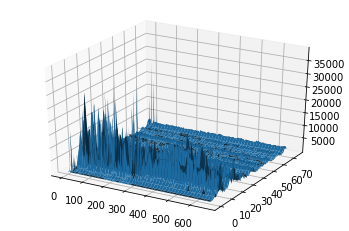

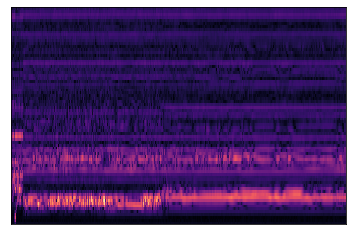

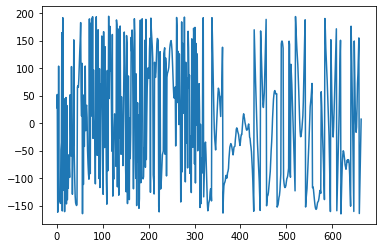

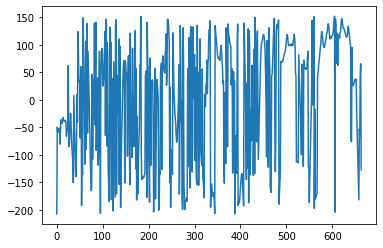

In [23]:

def visualizer (path):
  data= pd.read_csv(path)
  data=np.array(data)
  data=data.T
  X, Y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
  ax = plt.axes(projection = '3d')
  ax.plot_surface(X, Y, data)
  plt.show()
  librosa.display.specshow(data**0.5)
  plt.show()
  

def two_person_range(path):
  data= pd.read_csv(path)
  data=np.array(data)
  data=data.T
  p1=np.zeros((data.shape[1],1))
  p2=np.zeros((data.shape[1],1))
  for i in range(data.shape[1]):
    peak_positions=(scipy.signal.find_peaks(np.array(data[:,i]))[0])
    peaks=scipy.signal.peak_prominences(data[:,i], peak_positions)
    prom_peaks=np.argsort(peaks[0])[len(peaks[0])-2:len(peaks[0])]
    prom_peaks=peak_positions[prom_peaks]
    p1[i]=min(prom_peaks)
    p2[i]=max(prom_peaks)
  return p1.T,p2.T


def find_max_freq_bin(path):
  data= pd.read_csv(path)
  data=np.array(data)
  freq_bins=np.argmax(data,axis=1)
  return freq_bins


def phase_visualizer(phasearray):
  phasearray=phasearray-np.mean(phasearray)
  plt.plot(phasearray)
  plt.show()
  #y=plt.magnitude_spectrum(phasearray.reshape(len(phasearray)),pad_to=1024)
  #peak_positions=(scipy.signal.find_peaks(np.array(y[0]))[0])
  #peak_frequencies=y[1][peak_positions]
  #peak_mags=y[0][peak_positions]
  #plt.scatter(peak_frequencies,peak_mags,edgecolors='r')
  #print(y[1][np.argmax(y[0])])


def phase_finder(phasearray,max_bins):
  peakarray=np.zeros((len(phasearray),1))
  for i in range(len(phasearray)):
    peakarray[i]=phasearray[i,int(max_bins[i])]
  return peakarray


phasearray=np.array(pd.read_csv(phase_dir))
visualizer(mag_dir)
max_bins_2ppl=two_person_range(mag_dir)
#max_bins=find_max_freq_bin(mag_dir)

near_person=max_bins_2ppl[0].flatten()
far_person=max_bins_2ppl[1].flatten()
#far_person=np.ones(far_person.shape)*30
peakarray_near=phase_finder(phasearray,list(near_person))
phase_visualizer(peakarray_near)

peakarray_far=phase_finder(phasearray,list(far_person))
phase_visualizer(peakarray_far)


In [24]:

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def get_bpm(y,fs):
  mag_spec=plt.magnitude_spectrum(y,Fs=fs,pad_to=1024)
  plt.show()
  heart_freq=mag_spec[1][np.argmax(mag_spec[0])]
  if np.max(mag_spec[0])>3:
    return heart_freq*60
  else:
    return 0

def detect_rythym(y,fs):
  x=plt.specgram(y,NFFT=200,Fs=fs,noverlap=150,pad_to=256)
  max_freqs=np.argmax(x[0],axis=0)
  bpms=x[1][max_freqs]*60
  return [bpms,x[2]]
  
def detect_same_range(y,fs):
  mag_spec=plt.magnitude_spectrum(y,Fs=fs,pad_to=1024)
  peak_positions=(scipy.signal.find_peaks(np.array(mag_spec[0]),height=np.max(np.array(mag_spec[0]))*0.75)[0])
  peak_frequencies=mag_spec[1][peak_positions]
  print(peak_frequencies*60)
  #return [heart_freq1, heart_freq1]

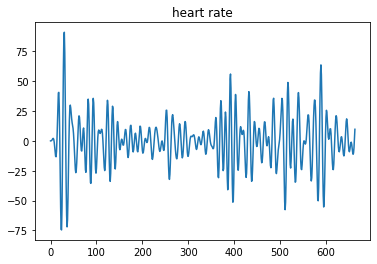

[12 12 13 19 10 10 11 12  6 13 11 11  9  8 12 10 10 12  8 15 13 10 13 15
 12 13  6 11 10 11 16 11 10 11 11 11  6 12 12 10 12  9 11 18 13 11 12 12
  9 14 14 12  9 12 12 11 10]


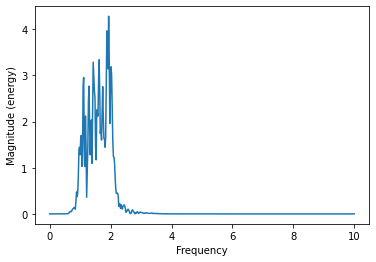

116.015625
2heartbeats:


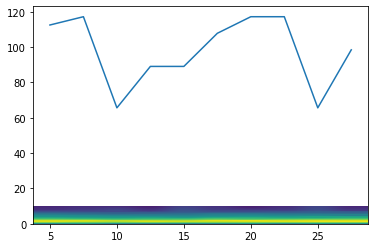

In [25]:
y=butter_bandpass_filter(phasearray[:,1],1,2,20)
plt.plot(y)
plt.title("heart rate")
plt.show()
peaks=(scipy.signal.find_peaks(np.array(y)))
print(np.diff(peaks[0]))
print(get_bpm(y,20))
params=detect_rythym(y,20)
time=params[1]
bpms=params[0]
plt.plot(time,bpms)
print("2heartbeats:")
#print(detect_same_range(y,20))

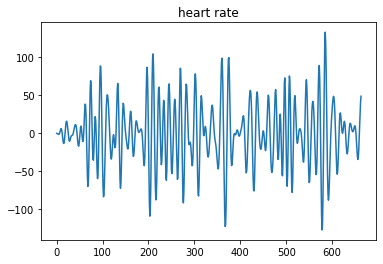

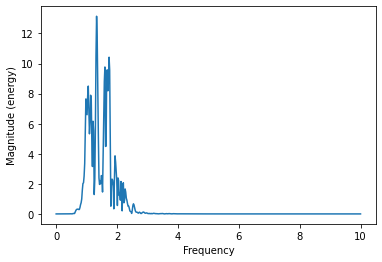

hearbeat is  79.6875


[array([ 65.625 ,  93.75  ,  98.4375, 103.125 , 103.125 ,  65.625 ,
         79.6875,  84.375 , 103.125 ,  89.0625]),
 array([ 5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. , 27.5])]

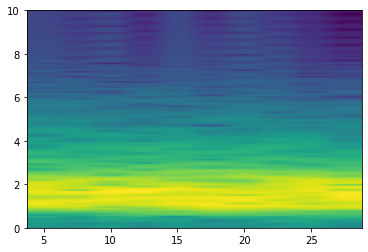

In [26]:
#far person
y1=butter_bandpass_filter(peakarray_far.T[0,:],1,2,20)
plt.plot(y1)
plt.title("heart rate")
plt.show()
print("hearbeat is ",get_bpm(y1,20))
detect_rythym(y1,20)

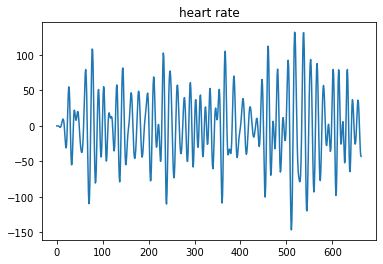

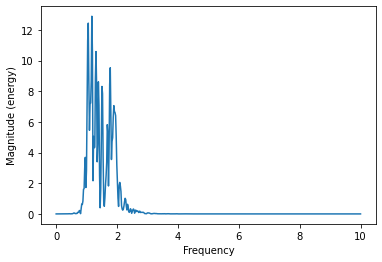

70.3125


[array([89.0625, 70.3125, 70.3125, 75.    , 79.6875, 65.625 , 65.625 ,
        60.9375, 65.625 , 75.    ]),
 array([ 5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. , 27.5])]

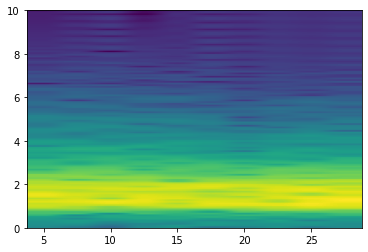

In [27]:
#near person
y1=butter_bandpass_filter(peakarray_near.T[0,:],1,2,20)
plt.plot(y1)
plt.title("heart rate")
plt.show()
print(get_bpm(y1,20))
detect_rythym(y1,20)

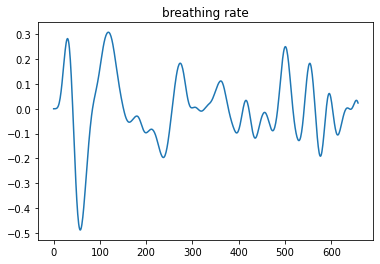

[88 62 31 63 31 56 55 40 45 53 42 39 19]


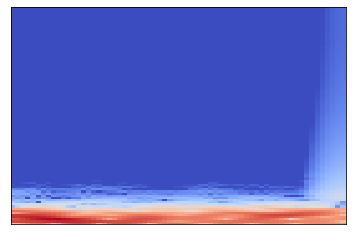

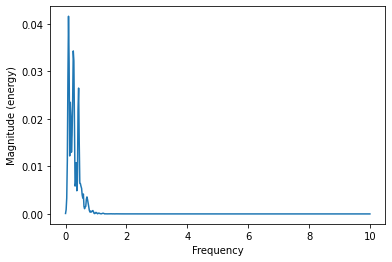

5.859375


In [ ]:
y=butter_bandpass_filter(phasearray[:,1],0.1,0.5,20)
plt.title("breathing rate")
plt.plot(y)
plt.show()
peaks=(scipy.signal.find_peaks(np.array(y)))
print(np.diff(peaks[0]))
stft = librosa.core.stft(y, hop_length=10, n_fft=200)
stft = librosa.amplitude_to_db(abs(stft))
librosa.display.specshow(stft)
plt.show()
print(get_bpm(y,20))